# Set up


In [ ]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"yuzhongfinally","key":"da5ea7094c4adb8f29251a2e3b240da7"}
with open('/content/gdrive/MyDrive/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 /content/gdrive/MyDrive/.kaggle/kaggle.json
!cp /content/gdrive/MyDrive/.kaggle/kaggle.json /root/.kaggle/
!kaggle config set -n path -v /content/gdrive/MyDrive/

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: /content/gdrive/MyDrive/


In [ ]:
!kaggle competitions download -c 11785-spring2021-hw4p2
%cd competitions
!ls

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
/content/gdrive/MyDrive/competitions
11785-spring2021-hw2p2s1-face-classification
11785-spring2021-hw2p2s2-face-verification
11785-spring2021-hw3p2
11785-spring2021-hw4p2
classification_sample_submission.csv
classification_test.txt
hw2p2.zip
hw5
verification_pairs_test.txt
verification_sample_submission.csv


In [ ]:

"""
!unzip dev.npy.zip
!unzip dev_labels.npy.zip
!unzip sample.csv.zip

!pwd

!unzip train.npy.zip
!unzip train_transcripts.npy.zip
!unzip dev.npy.zip
!unzip dev_transcripts.npy.zip
"""


/content/gdrive/MyDrive/competitions/11785-spring2021-hw4p2
Archive:  train.npy.zip
replace train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train_transcripts.npy.zip
replace train_transcripts.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  dev.npy.zip
replace dev.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: unzip:  cannot find or open dev_transcripts.npy.zip, dev_transcripts.npy.zip.zip or dev_transcripts.npy.zip.ZIP.


In [2]:
%cd competitions/11785-spring2021-hw4p2
!ls

/content/gdrive/MyDrive/competitions/11785-spring2021-hw4p2
ctcdecode	     LAS2	     test.npy
dev.npy		     LAS3	     test.npy.zip
dev.npy.zip	     LAS4	     train.npy
dev_transcripts.npy  LAS5	     train.npy.zip
hw4p2_simple	     LASbest	     train_transcripts.npy
hw4p2_simple.zip     s21_sample.csv  train_transcripts.npy.zip
LAS1		     submission.csv


# preprocessing

In [3]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data
from torch.autograd import Variable


cuda = torch.cuda.is_available()
print(cuda, sys.version)
device = torch.device("cuda" if cuda else "cpu")
np.random.seed(5111785)
torch.manual_seed(5111785)

LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
         'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']


True 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [4]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    letter2index = {}
    index2letter = {}
    
    for num, val in enumerate(letter_list):
      letter2index[val] = num
      index2letter[num] = val

    return letter2index, index2letter
    
def transform_letter_to_index(raw_transcripts, letter2index):
    '''
    Transforms text input to numerical input by converting each letter 
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )
    
    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''  
    transcripts = []
    for row in raw_transcripts: #which go through line

      start = letter2index['<sos>']
      sub = [start]

      for word in row:
       
        #w = word
        #w = str(word, 'utf-8')
        w = word.decode(encoding='UTF-8')
        for letter in w:
          
          idx = letter2index[letter]
          sub.append(idx)
        sub.append(letter2index[' '])

      sub_len = len(sub) - 1
      sub = sub[0:sub_len] 
      ending = letter2index['<eos>']
      sub.append(ending)

      transcripts.append(sub)

    return transcripts
    
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [5]:


def translate(index, stopidx, startidx):
  index_letter = []
  for r in index:
    curr = ""
    for i in r:
      if i in stopidx:
        break
      elif i not in stopidx and i not in startidx:
        curr += index2letter[i]
    index_letter.append(curr)
  return index_letter

In [6]:

# Load the training, validation and testing data
train_data = np.load('train.npy', allow_pickle=True, encoding='bytes')
valid_data = np.load('dev.npy',   allow_pickle=True, encoding='bytes')
#test_data = np.load('test.npy', allow_pickle=True, encoding='bytes')

# Load the training, validation raw text transcripts
raw_train_transcript = np.load('train_transcripts.npy', allow_pickle=True,encoding='bytes')
raw_valid_transcript = np.load('dev_transcripts.npy',   allow_pickle=True,encoding='bytes')
#train_data = np.load('hw4p2_simple/train.npy', allow_pickle=True, encoding='bytes')
#raw_train_transcript = np.load('hw4p2_simple/train_transcripts.npy', allow_pickle=True,encoding='bytes')
#valid_data = np.load('hw4p2_simple/dev.npy', allow_pickle=True, encoding='bytes')
#raw_valid_transcript = np.load('hw4p2_simple/dev_transcripts.npy', allow_pickle=True, encoding='bytes')

In [7]:
train_transcript = transform_letter_to_index(raw_train_transcript, letter2index)
valid_transcript = transform_letter_to_index(raw_valid_transcript, letter2index)

In [8]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        # For testing set, return only x
        if self.Y == None:
            return torch.tensor(self.X[index].astype(np.float32))
        # For training and validation set, return x and y
        else:
          
            return torch.tensor(self.X[index].astype(np.float32)), torch.tensor(self.Y[index])
from tensorflow.keras.preprocessing.sequence import pad_sequences

def collate_train_val(batch):
  sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
  sequences = [x[0] for x in sorted_batch]
  labels = [x[1] for x in sorted_batch]
  sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
  labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
  seq_lengths = torch.LongTensor([len(x) for x in sequences])
  label_lengths = torch.LongTensor([len(x) for x in labels])

  return sequences_padded, labels_padded, seq_lengths, label_lengths



In [9]:
# Create datasets
train_dataset = MyDataset(train_data, train_transcript)
train_loader_args = dict(shuffle = True, batch_size = 64, num_workers = 0, collate_fn = collate_train_val, pin_memory = True) 

valid_dataset = MyDataset(valid_data, valid_transcript)
valid_loader_args = dict(shuffle = False, batch_size = 64, num_workers = 0, collate_fn = collate_train_val, pin_memory = True) 
#test_dataset = 

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,**train_loader_args)
valid_loader = torch.utils.data.DataLoader(valid_dataset,**valid_loader_args)

# model

In [10]:

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [11]:

class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.
    '''
    def __init__(self, input_dim, hidden_dim):
      super(pBLSTM, self).__init__()
      self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True, dropout = 0)
      self.drop = LockedDropout()

    def forward(self, x):
 
      x, length_long = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
      batch = len(x)
      length, insize = x[0].shape

      x = x[:, :(length//2)*2, :]
      x = self.drop(x, dropout = 0.5)
      length_long = length_long//2
      
      
      x = x.reshape( batch, int(length/2),insize*2)   
      x = nn.utils.rnn.pack_padded_sequence(x, length_long, enforce_sorted=False, batch_first=True)
      
      output, hidden = self.blstm(x)
      #output = self.drop(output)
   
      return output

In [12]:

class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.
    Key and value are linear projections of the output from pBLSTM network for the laster.
    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):

      super(Encoder, self).__init__()
      # The first LSTM at the very bottom
      self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, 
                          num_layers=3, bidirectional=True, batch_first=True)
      self.drop = LockedDropout()


      # TODO: Define the blocks of pBLSTMs
      # ...
      self.plstms = torch.nn.Sequential(
          pBLSTM(encoder_hidden_dim*4, encoder_hidden_dim),
          
          pBLSTM(encoder_hidden_dim*4, encoder_hidden_dim),

          pBLSTM(encoder_hidden_dim*4, encoder_hidden_dim),
         
      )
      # The linear transformation for producing Key and Value for attention
      # Since you are using bidirectional LSTM, be careful about the size of hidden dimension
      self.key_network = nn.Linear(encoder_hidden_dim*2, key_value_size)
      self.value_network = nn.Linear(encoder_hidden_dim*2, key_value_size)

    def forward(self, x, x_len):

      # Pass through the first LSTM at the very bottom
    
      packed_sequence = rnn_utils.pack_padded_sequence(x, x_len,  batch_first=True, enforce_sorted=False) 

      packed_out,_= self.lstm(packed_sequence)
      
      packed_out = self.plstms(packed_out)
   
      # Unpack the sequence and get the Key and Value for attention
      unpacked, unpacked_x_len = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

      #unpacked = self.drop(unpacked)

      key = self.key_network(unpacked)
      value = self.value_network(unpacked)

      #print('key',key.shape)
      return key, value, unpacked_x_len

In [13]:
def plot_attention(attention):
    attention = attention.cpu()
    attention = attention.detach().numpy()
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()
    def forward(self, query, key, value,  lengths):
        
        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)

        mask = torch.arange(key.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)
        mask = mask.to(device)

        energy.masked_fill_(mask, -1e9)

        attention = nn.functional.softmax(energy, dim = 1)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)

        return context, attention


In [27]:
import torch.nn.functional as F
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the seond LSTMCell can be used as query for calculating attention.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim,key_value_size=128):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<eos>'])
       
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
        self.fc1 = nn.Linear(embed_dim, vocab_size)
        self.fc2 = nn.Linear(vocab_size, embed_dim)
        self.attention = Attention()     
        self.vocab_size = vocab_size
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size)
        self.key_value_size = key_value_size
    

        self.fc1.weight = self.embedding.weight
        #self.character_prob.weight = self.embedding.weight

    def forward(self, key, value, encoder_len, y=None, plot = False,mode='train', teacher_force_rate = None):
        '''
        Args:
            key :(B, T, key_value_size) - Output of the Encoder Key projection layer
            value: (B, T, key_value_size) - Output of the Encoder Value projection layer
            y: (T, text_len) - Batch input of text with text_length
            mode: Train or eval mode
        Return:
            predictions: the character perdiction probability 
        '''

        B, key_seq_max_len, key_value_size = key.shape


        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)
        else:
            max_len = 600

        predictions = []
        prediction = torch.zeros(B, 1).to(device)
        hidden_states = [None, None]
        attplot = [] 
        
        # TODO: Initialize the context. Be careful here
        context = value[:,0,:]

        for i in range(max_len):
            if mode == 'train':
              # TODO: Implement (1) Teacher Forcing and (2) Gumble Noise techniques here
              # ...
              
              if y is None:
                teach_force_rate = 0
      
              teacher_force = True if np.random.random_sample() < teacher_force_rate else False

              if teacher_force == True and i == 0:

                zeros = torch.zeros(B).long()
                start = zeros.fill_(letter2index['<sos>']).to(device)
                char_embed = self.embedding(start)
                
              elif teacher_force == True and i > 0 :

                char_embed = char_embeddings[:, i-1,:]

              elif teacher_force == False and i == 0:

                char_embed = self.embedding(prediction.argmax(dim = -1))
                char_embed = torch.nn.functional.gumbel_softmax(char_embed, tau=1, hard=False)
      

              elif teacher_force == False and i != 0:
                
                char_embed = torch.nn.functional.gumbel_softmax(prediction).mm(self.embedding.weight)
            
            elif mode == 'eval':
              
              if i == 0:
                zeros = torch.zeros(B).long()
                start = zeros.fill_(letter2index['<sos>']).to(device)
                char_embed = self.embedding(start)
              else:
                char_embed = self.embedding(prediction.argmax(dim = -1))
      
            y_context = torch.cat([char_embed, context], dim=1)
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            lstm1_hidden = hidden_states[0][0]
            hidden_states[1] = self.lstm2(lstm1_hidden, hidden_states[1])
            output = hidden_states[1][0]
            output = self.fc1(output)
            output = self.fc2(output)
            #print('out2', output.shape)

            # TODO: Compute attention from the output of the second LSTM Cell
            # ...  attplot.append(attention[0].detach().cpu())

            context, attention = self.attention(output, key, value,  encoder_len)

            attplot.append(attention.squeeze().detach().cpu())
             
            output_context = torch.cat([output, context], dim=1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(1))

            
        #attention plot
        if plot == True: 
          atplot = [i[1] for i in attplot]
          plot_attention(torch.stack(atplot))

        return torch.cat(predictions, dim=1)

In [28]:

class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size=key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size=key_value_size)

    def forward(self, x, x_len,plotdecision,tf,y=None, mode='train', pretrain = True):
        """
        if pretrain == True:
          for params in self.encoder.parameters():
            params.requires_grad = False
        """
        key, value, encoder_len = self.encoder(x, x_len)
        if pretrain == True:
          for params in self.encoder.parameters():
            params.requires_grad = False
        else:
          for params in self.encoder.parameters():
            params.requires_grad = True

        predictions = self.decoder(key, value, encoder_len, y=y, plot = plotdecision,mode=mode, teacher_force_rate = tf)

        return predictions

In [29]:

!pip install Levenshtein
import Levenshtein as lev

def levdistance(preds, target):
  distance = []
  for s in range(len(preds)):
    distance.append(lev.distance(preds[s],target[s]))
  return distance


#training

In [30]:
def train(model, train_loader, criterion, optimizer, mode, epoch, tf):
    model.train()
    running_loss = 0
    
    counts = 0
    for batchnum, (x, y , seq_lengths, label_lengths) in enumerate(train_loader):
      
        
        optimizer.zero_grad()
        # 1) Set the inputs to the device.

        x, y = x.to(device), y.to(device)
        label_lengths = label_lengths.to(device)
      #  print('finish to device')

        # 2) Pass your inputs, and length of speech into the model.
        plotdecision = True if batchnum == 10 else False

        if epoch <10:
          pretrain =  True
        else: 
          pretrain = False
        preds = model(x, seq_lengths, plotdecision, tf,y,mode = 'train', pretrain = pretrain)
        
        # key, value, encoder_len, y=None, plot = False,mode='train', teacher_force_rate = 0.9, Gumbel = True

        # 3) Generate a mask based on the lengths of the text
        #    Ensure the mask is on the device and is the correct shape.   
        maxlen = torch.max(label_lengths).to(device)
    
        mask = torch.arange(maxlen)[None,:].to(device) < label_lengths[:, None].to(device)
    
        # 4. Calculate the loss and mask it to remove the padding part
        predssize = preds.size(2)
        loss = criterion(preds.view(-1, predssize), y.view(-1))
        
        maskloss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
        

        # 5. Backward on the masked loss
        maskloss.backward()
     
    
        # 6. Optional: Use torch.nn.utils.clip_grad_norm(model.parameters(), 2) to clip the gradie
        torch.nn.utils.clip_grad_norm(model.parameters(),2)

        # 7. Take a step with your optimizer
        optimizer.step()
        

        # 8. print the statistic (loss, edit distance and etc.) for analysis
        running_loss += maskloss.item()
        counts += 1
        del x
        del y
        del seq_lengths
        del label_lengths
        torch.cuda.empty_cache()

    print('epoch:', epoch, 'train loss: ',running_loss)


    
def val(model, valid_loader, epoch):
    model.eval()
    with torch.no_grad():
      running_loss = 0
      dist = []
      for x, y , seq_lengths, label_lengths in valid_loader:
        x, y = x.to(device), y.to(device)
        label_lengths = label_lengths.to(device)
        
        plotdecision = False
        tf = 0
        preds = model(x, seq_lengths, plotdecision, tf,y=None, mode = 'eval',pretrain = False)
    
        predtext = translate(preds.argmax(-1).detach().cpu().numpy(), [letter2index['<eos>']], [letter2index['<sos>']])
        
        ytext = translate(y.detach().cpu().numpy(),  [letter2index['<eos>']], [letter2index['<sos>']])
        dist.extend(levdistance(predtext, ytext))
        del x
        del y
        del seq_lengths
        del label_lengths
        torch.cuda.empty_cache()
      print('dist',np.mean(dist))
      if np.mean(dist) < 21:
        torch.save(model,'LAS5')
        print('model saving')
      for param_group in optimizer.param_groups:
      
        print(param_group['lr'])
        if param_group['lr'] > 0.0001 and epoch > 15 and epoch < 35:
          scheduler.step(np.mean(dist))
      
      
        


In [31]:

model = Seq2Seq(40, len(LETTER_LIST), 128,256, 128)
#input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128, pretrain = True
model = model.to(device)
n_epochs = 50
weightDecay = 5e-6
optimizer = optim.Adam(model.parameters(), lr=0.003,  weight_decay = weightDecay)

scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.75,1)
criterion = nn.CrossEntropyLoss(reduction = 'none')

mode = 'train'
tf = {'pretrain':0.95, 'regular':0.95}
for n in range(n_epochs):
  #torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.8)
  if n< 10 :
    tf['pretrain'] -= 0.01
    tf_current = tf['pretrain']
  else:
    tf['regular'] -=0.006
    tf_current = tf['regular']
  train(model, train_loader, criterion, optimizer, mode, n, tf_current)

  for param_group in optimizer.param_groups:
    print(param_group['lr'])
  val(model, valid_loader, n)
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


KeyboardInterrupt: ignored

0.79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


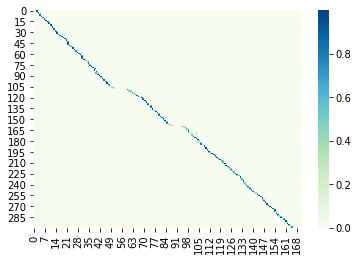

epoch: 30 train loss:  201.95280343294144
0.001
dist 36.98668146503885
0.001
0.78


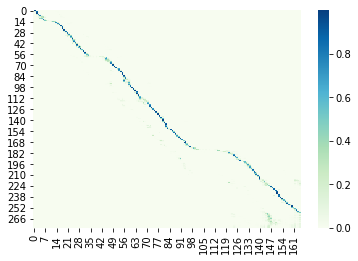

epoch: 31 train loss:  195.33969524502754
0.001
dist 36.166481687014425
0.001
0.77


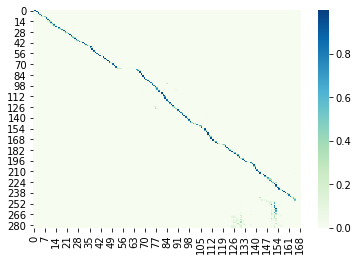

epoch: 32 train loss:  197.0557226240635
0.001
dist 35.74657787643359
0.001
0.76


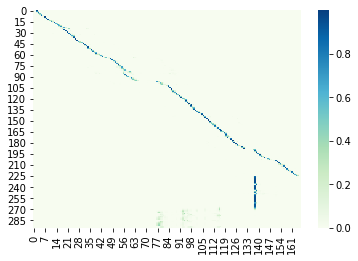

epoch: 33 train loss:  194.71480229496956
0.001
dist 35.250092489826116
0.001
0.75


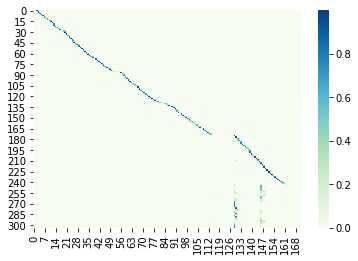

epoch: 34 train loss:  199.66114553809166
0.001
dist 33.153163152053274
0.001
0.74


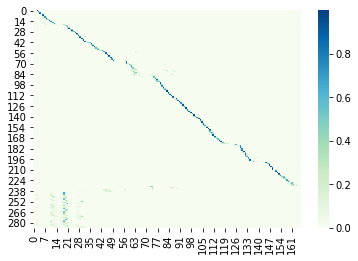

epoch: 35 train loss:  198.62788972258568
0.001
dist 34.965223825379205
0.001
0.73


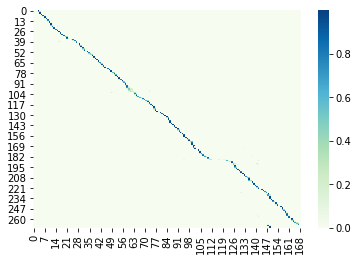

epoch: 36 train loss:  197.99928948283195
0.001
dist 33.374398816130224
0.001
0.72


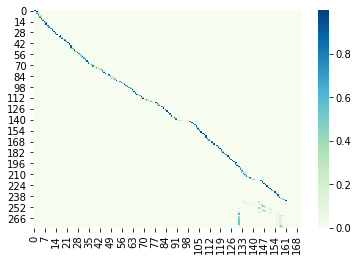

epoch: 37 train loss:  210.84831219911575
0.001
dist 34.81058083610803
0.001
0.71


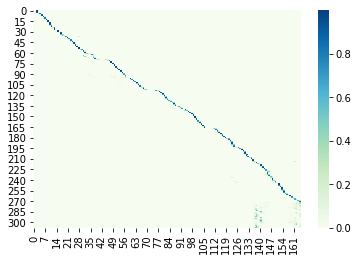

epoch: 38 train loss:  208.36768978834152
0.001
dist 34.64927857935627
0.001
0.7


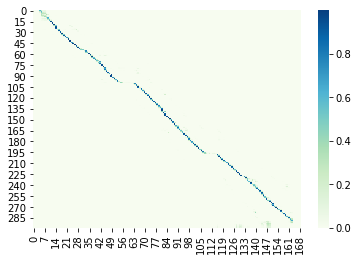

epoch: 39 train loss:  214.2237620651722
0.001
dist 33.847206807251204
0.001


In [ ]:
#model = torch.load('LASbest')
mode = 'train'
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-6)

scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.75,1)
criterion = nn.CrossEntropyLoss(reduction = 'none')


tf = {'pretrain':0.95, 'regular':0.80}

for n in range(30,40):
  #torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.8)
  if n< 10 :
    tf['pretrain'] -= 0.02
    tf_current = tf['pretrain']
  else:
    tf['regular'] -=0.01
    tf_current = tf['regular']
    print(tf_current)
  train(model, train_loader, criterion, optimizer, mode, n, tf_current)

  for param_group in optimizer.param_groups:
    print(param_group['lr'])
  val(model, valid_loader, n)

# testing


In [ ]:
del train_loader
del valid_loader

In [ ]:
#!unzip test.npy.zip
test = np.load('test.npy', allow_pickle = True)

In [ ]:
class Dataset_test(torch.utils.data.Dataset):
  def __init__(self, X):
    self.X = np.array(X)

    self.length = len(self.X)
    self.Y = np.zeros(self.length)
    
  def __len__(self):
      
    return self.length
    
  def __getitem__(self, index):
  
    xx = torch.from_numpy(self.X[index])
    yy = torch.from_numpy(self.X[index])
     
    return xx, yy


In [ ]:
def pad_sequences(batch):
  #sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)

  sorted_batch = batch
  sequences = [x[0] for x in sorted_batch]
  labels = [x[1] for x in sorted_batch]
  sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
  labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

  seq_lengths = torch.LongTensor([len(x) for x in sequences])
  label_lengths = torch.LongTensor([len(x) for x in labels])

  return sequences_padded, labels_padded,seq_lengths, label_lengths


In [ ]:

dataset = Dataset_test(test)
test_loader_args = dict(shuffle = False, batch_size = 128, num_workers = 0, collate_fn = pad_sequences) 
test_loader = torch.utils.data.DataLoader(dataset,**test_loader_args)

In [ ]:
preds = []
for batch_num, (x, y, seq_len,label_len) in enumerate(test_loader):
  x = x.to(device)

  outputs = model(x, seq_len,False, 0,y=None, mode = 'eval',pretrain = False)
  predtext = translate(outputs.argmax(-1).detach().cpu().numpy(), [letter2index['<eos>']], [letter2index['<sos>']])
  preds.extend(predtext)
  del x
  del y
  

In [ ]:
import pandas as pd
df = pd.DataFrame({'id':np.arange(len(preds)), "label":preds})
print(df)
df.to_csv(r"submission.csv", index=False)

        id                                              label
0        0  yesterday were trembling for he health that hi...
1        1  we were a worn entrastic in the centinacle con...
2        2     said sir but i must have money to do that what
3        3  as the regards my robbing the company i'll say...
4        4  but they could not and a provemitation and sle...
...    ...                                                ...
2615  2615  i think i must show you my patch work girl sai...
2616  2616          who began the quarter was at the vormance
2617  2617  this missus poyse  said blussie and believing ...
2618  2618  there was infinite scaptices and ran to him in...
2619  2619                       but his mother hundred close

[2620 rows x 2 columns]


In [ ]:
!kaggle competitions submit -c 11785-homework-4-part-2-las-slack -f submission.csv -m "Message"

100% 293k/293k [00:06<00:00, 47.8kB/s]
Successfully submitted to 11785 Homework 4 Part 2 : LAS - Slack